# Neural Network Model

## Definition

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import sklearn as skl
import pickle
from sklearn.datasets import make_classification
import numpy as np
import pymongo
import requests
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns



## Import data from MONGODB

In [2]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
# Pull data from DB
results = client.census_DB.census.find()
cluster_data = []
for result in results:
    del result['_id']
    cluster_data.append(result)

In [4]:
#Visualize data in df
cleaned_census_data = pd.DataFrame(cluster_data)
cleaned_census_data

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican
...,...,...,...,...,...,...,...,...,...,...
9002,2020,MINNESOTA,MN,RENVILLE,14572.0,44.0,58542.0,31243.0,9.422180,Republican
9003,2020,MINNESOTA,MN,ROSEAU,15259.0,41.6,62304.0,31452.0,7.425126,Republican
9004,2020,MINNESOTA,MN,SHERBURNE,96015.0,36.1,88671.0,36022.0,5.158569,Republican
9005,2020,MINNESOTA,MN,STEELE,36710.0,39.2,68172.0,34648.0,7.864342,Republican


## Pre-process data for use in Neural Network Model

In [5]:
# Select data from the years we want to analyze
cleaned_census_data_nn_analyze = cleaned_census_data[(cleaned_census_data['year'] < 2020)]
cleaned_census_data_nn_analyze.head()

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,2012,MISSOURI,MO,LINN,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,2012,MISSOURI,MO,HOWELL,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,2012,MISSOURI,MO,JOHNSON,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,2012,MISSOURI,MO,LACLEDE,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,2012,MISSOURI,MO,MARIES,9140.0,43.1,44885.0,21883.0,14.070022,Republican


In [6]:
# Drop the non-beneficial ID columns.
cleaned_census_data_nn_analyze = cleaned_census_data_nn_analyze.drop(['year','state','state_po','county_name'], axis = 1)
cleaned_census_data_nn_analyze.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,12668.0,43.0,39028.0,20968.0,13.245974,Republican
1,40330.0,39.6,34148.0,17763.0,20.300025,Republican
2,52964.0,29.7,47960.0,21375.0,15.246205,Republican
3,35507.0,39.1,39101.0,19788.0,18.244290,Republican
4,9140.0,43.1,44885.0,21883.0,14.070022,Republican


In [7]:
# Determine the number of unique values in each column.
column_unique_count = cleaned_census_data_nn_analyze.nunique()
column_unique_count

Population           5798
Median Age            330
Household Income     5494
Per Capita Income    5072
Poverty Rate         6002
Winner                  2
dtype: int64

In [8]:
# For columns with more than 2 unique values, determine the number of data points for each unique value
data_points = list(column_unique_count[column_unique_count>2].index)
print(data_points)

for x in data_points:
    print(cleaned_census_data_nn_analyze[x].value_counts())

['Population', 'Median Age', 'Household Income', 'Per Capita Income', 'Poverty Rate']
11526.0     3
16892.0     3
2095.0      3
14119.0     3
20324.0     3
           ..
5751.0      1
725.0       1
2753.0      1
7779.0      1
284559.0    1
Name: Population, Length: 5798, dtype: int64
41.2    71
40.4    69
40.3    65
40.2    64
40.8    62
        ..
53.7     1
24.6     1
54.9     1
25.1     1
57.4     1
Name: Median Age, Length: 330, dtype: int64
45000.0    4
38155.0    4
37750.0    4
43529.0    4
46071.0    4
          ..
49075.0    1
44426.0    1
39950.0    1
44106.0    1
46842.0    1
Name: Household Income, Length: 5494, dtype: int64
21716.0    4
24099.0    4
21696.0    4
21883.0    4
17504.0    4
          ..
22943.0    1
26062.0    1
22743.0    1
19421.0    1
26083.0    1
Name: Per Capita Income, Length: 5072, dtype: int64
7.142857     2
10.000000    2
16.000000    2
20.000000    2
13.245974    1
            ..
15.724931    1
19.808475    1
13.288922    1
23.166879    1
20.784793  

In [9]:
# Convert categorical data to numeric with `pd.get_dummies`
data_dummies = pd.get_dummies(cleaned_census_data_nn_analyze)
data_dummies.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner_Democrat,Winner_Republican
0,12668.0,43.0,39028.0,20968.0,13.245974,0,1
1,40330.0,39.6,34148.0,17763.0,20.300025,0,1
2,52964.0,29.7,47960.0,21375.0,15.246205,0,1
3,35507.0,39.1,39101.0,19788.0,18.244290,0,1
4,9140.0,43.1,44885.0,21883.0,14.070022,0,1


In [10]:
# Define final dataset to analyze
nn_analyze_data_target = data_dummies.drop('Winner_Democrat', axis=1).rename(columns={"Winner_Republican": "Winner"})
nn_analyze_data_target.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
0,12668.0,43.0,39028.0,20968.0,13.245974,1
1,40330.0,39.6,34148.0,17763.0,20.300025,1
2,52964.0,29.7,47960.0,21375.0,15.246205,1
3,35507.0,39.1,39101.0,19788.0,18.244290,1
4,9140.0,43.1,44885.0,21883.0,14.070022,1


In [11]:
# Split our preprocessed data into our features and target arrays
X = nn_analyze_data_target.drop('Winner', axis=1)
y = nn_analyze_data_target['Winner']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
# Create a StandardScaler instances
X_scaler = skl.preprocessing.StandardScaler()

# Fit the StandardScaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Compile, Train and Evaluate the Model

In [13]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

def create_model(hp):
    nn_model = tf.keras.models.Sequential()
    
    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=2, input_shape=(X_train_scaled.shape[1],)))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
        
    # Output layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    
    # Compile the model
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return nn_model


In [14]:
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [15]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

INFO:tensorflow:Oracle triggered exit


In [16]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 9,
 'num_layers': 4,
 'units_0': 1,
 'units_1': 7,
 'units_2': 9,
 'units_3': 9,
 'units_4': 1,
 'units_5': 1,
 'tuner/epochs': 12,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 4,
 'tuner/round': 2,
 'tuner/trial_id': '0105'}

In [17]:
# Evaluate the model using the test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

47/47 - 0s - loss: 0.3692 - accuracy: 0.8715 - 471ms/epoch - 10ms/step
Loss: 0.369234561920166, Accuracy: 0.8715046644210815


In [18]:
# Predict the outcome for the test set
y_target = y_test
y_pred_prob = best_model.predict(X_test_scaled)
y_pred_class = []

for each in y_pred_prob:
    if(each > 0.5):
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

results = {'Prediction': y_pred_class, 'Target': y_target}
results_df = pd.DataFrame(data=results)
results_df


47/47 [==============================] - 0s 1ms/step


,Prediction,Target
79,1,0
3043,1,1
4851,1,1
1168,1,1
3573,1,1
...,...,...
3034,1,1
2083,1,1
1616,1,0
5487,1,1


Classification report:
              precision    recall  f1-score   support

           0       0.75      0.47      0.57       279
           1       0.89      0.96      0.92      1223

    accuracy                           0.87      1502
   macro avg       0.82      0.71      0.75      1502
weighted avg       0.86      0.87      0.86      1502

ROC AUC score: 0.715


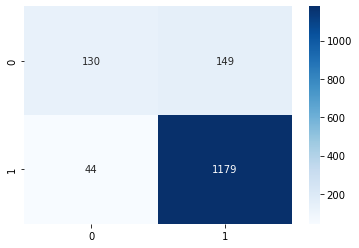

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Compute and print the classification report
cr = classification_report(y_test, y_pred_class)
print("Classification report:")
print(cr)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_class)
print(f"ROC AUC score: {roc_auc:.3f}")

# Use the Model to predict an outcome using new dataset

In [20]:
# Get new data 2020 data from the data set
cleaned_census_data_nn_validate = cleaned_census_data[(cleaned_census_data['year'] == 2020)]
cleaned_census_data_nn_validate.head()

,year,state,state_po,county_name,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
6006,2020,ALABAMA,AL,AUTAUGA,55639.0,38.6,57982.0,29804.0,15.086540,Republican
6007,2020,ALABAMA,AL,BALDWIN,218289.0,43.2,61756.0,33751.0,9.042599,Republican
6008,2020,ALABAMA,AL,BARBOUR,25026.0,40.1,34990.0,20074.0,25.221769,Republican
6009,2020,ALABAMA,AL,BIBB,22374.0,39.9,51721.0,22626.0,16.782873,Republican
6010,2020,ALABAMA,AL,BLOUNT,57755.0,41.0,48922.0,25457.0,13.586702,Republican


In [21]:
# Drop the non-beneficial ID columns.
cleaned_census_data_nn_validate = cleaned_census_data_nn_validate.drop(['year','state','state_po','county_name'], axis = 1)
cleaned_census_data_nn_validate.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
6006,55639.0,38.6,57982.0,29804.0,15.086540,Republican
6007,218289.0,43.2,61756.0,33751.0,9.042599,Republican
6008,25026.0,40.1,34990.0,20074.0,25.221769,Republican
6009,22374.0,39.9,51721.0,22626.0,16.782873,Republican
6010,57755.0,41.0,48922.0,25457.0,13.586702,Republican


In [22]:
# Convert categorical data to numeric with `pd.get_dummies`
data_dummies = pd.get_dummies(cleaned_census_data_nn_validate)
data_dummies.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner_Democrat,Winner_Republican
6006,55639.0,38.6,57982.0,29804.0,15.086540,0,1
6007,218289.0,43.2,61756.0,33751.0,9.042599,0,1
6008,25026.0,40.1,34990.0,20074.0,25.221769,0,1
6009,22374.0,39.9,51721.0,22626.0,16.782873,0,1
6010,57755.0,41.0,48922.0,25457.0,13.586702,0,1


In [23]:
# Define final dataset to validate
nn_validate_data_target = data_dummies.drop('Winner_Democrat', axis=1).rename(columns={"Winner_Republican": "Winner"})
nn_validate_data_target.head()

,Population,Median Age,Household Income,Per Capita Income,Poverty Rate,Winner
6006,55639.0,38.6,57982.0,29804.0,15.086540,1
6007,218289.0,43.2,61756.0,33751.0,9.042599,1
6008,25026.0,40.1,34990.0,20074.0,25.221769,1
6009,22374.0,39.9,51721.0,22626.0,16.782873,1
6010,57755.0,41.0,48922.0,25457.0,13.586702,1


In [24]:
# Split our preprocessed data into our features and target arrays
X = nn_validate_data_target.drop('Winner', axis=1)
y = nn_validate_data_target['Winner']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
# Create a StandardScaler instances
X_scaler = skl.preprocessing.StandardScaler()

# Fit the StandardScaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Run the model with new dataset
y_target = y_test
y_pred_prob = best_model.predict(X_test_scaled)
y_pred_class = []

for each in y_pred_prob:
    if(each > 0.5):
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

results = {'Prediction': y_pred_class, 'Target': y_target}
results_df = pd.DataFrame(data=results)
results_df

24/24 [==============================] - 0s 1ms/step


,Prediction,Target
7807,0,1
7196,1,1
7823,1,1
6257,1,1
8511,1,1
...,...,...
7781,1,0
8847,1,1
7741,1,1
6185,1,1


Classification report:
              precision    recall  f1-score   support

           0       0.70      0.47      0.56       126
           1       0.90      0.96      0.93       625

    accuracy                           0.88       751
   macro avg       0.80      0.71      0.75       751
weighted avg       0.87      0.88      0.87       751

ROC AUC score: 0.714


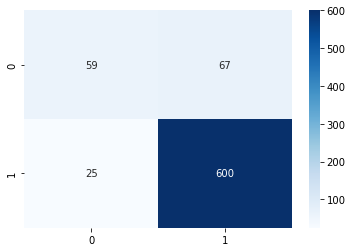

In [27]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
# create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Compute and print the classification report
cr = classification_report(y_test, y_pred_class)
print("Classification report:")
print(cr)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_class)
print(f"ROC AUC score: {roc_auc:.3f}")